In [13]:
!pip install keras-tuner
!pip install kaggle
import kagglehub
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner import HyperParameters
from keras_tuner.tuners import Hyperband
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [14]:
# Constants
BATCH_SIZE = 32
IMG_HEIGHT = 96
IMG_WIDTH = 96
NUM_CLASSES = 25

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [15]:
# Preprocess Function
def preprocess_image(image, label):
    image = tf.reshape(image, [28, 28, 1])
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.image.grayscale_to_rgb(image)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [16]:
# Load Dataset from DataFrame
def load_dataset_from_dataframe(dataframe):
    labels = dataframe.iloc[:, 0].values
    images = dataframe.iloc[:, 1:].values.reshape((-1, 28, 28))
    labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    dataset = dataset.map(preprocess_image)
    dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

In [17]:
# Load Data
path = kagglehub.dataset_download("datamunge/sign-language-mnist")
print("Path to dataset files:", path)

train_data = pd.read_csv(f"{path}/sign_mnist_train.csv")
test_data = pd.read_csv(f"{path}/sign_mnist_test.csv")

train_val_split = int(len(train_data) * 0.9)
train_df = train_data.iloc[:train_val_split]
val_df = train_data.iloc[train_val_split:]

train_dataset = load_dataset_from_dataframe(train_df)
val_dataset = load_dataset_from_dataframe(val_df)
test_dataset = load_dataset_from_dataframe(test_data)


100%|██████████| 62.6M/62.6M [00:04<00:00, 15.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1


In [18]:
# Model Builder Function
def model_builder(hp):
    base_model = MobileNetV3Small(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(hp.Int('dense_units', 128, 512, step=64), activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = Dropout(hp.Float('dropout_rate', 0.2, 0.6, step=0.1))(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [19]:
# Hyperparameter Tuning
tuner = Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_dir',
    project_name='mobilenetv3_tuning'
)

stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(train_dataset, validation_data=val_dataset, callbacks=[stop_early])

Trial 27 Complete [00h 03m 02s]
val_accuracy: 0.4828841984272003

Best val_accuracy So Far: 0.9664967060089111
Total elapsed time: 00h 30m 18s

Search: Running Trial #28

Value             |Best Value So Far |Hyperparameter
320               |448               |dense_units
0.3               |0.3               |dropout_rate
0.001             |0.001             |learning_rate
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.3769 - loss: 2.1134 - val_accuracy: 0.7382 - val_loss: 1.0029
Epoch 2/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6369 - loss: 1.1738 - val_accuracy: 0.8234 - val_loss: 0.6708
Epoch 3/10
771/773 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6978 - loss: 0.9812

KeyboardInterrupt: 

In [20]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [21]:
# Print the best hyperparameters

print(f"""
Best dense units: {best_hps.get('dense_units')},
Best dropout rate: {best_hps.get('dropout_rate')},
Best learning rate: {best_hps.get('learning_rate')},
""")


Best dense units: 448,
Best dropout rate: 0.30000000000000004,
Best learning rate: 0.001,



In [22]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

In [24]:
# Fine-tune the base model
base_model = MobileNetV3Small(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[stop_early, ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)]
)

Epoch 1/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.3924 - loss: 2.0768 - val_accuracy: 0.7578 - val_loss: 0.9295 - learning_rate: 0.0010
Epoch 2/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.6541 - loss: 1.1313 - val_accuracy: 0.8365 - val_loss: 0.6546 - learning_rate: 0.0010
Epoch 3/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.7256 - loss: 0.9157 - val_accuracy: 0.8827 - val_loss: 0.5247 - learning_rate: 0.0010
Epoch 4/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7734 - loss: 0.7836 - val_accuracy: 0.8948 - val_loss: 0.4667 - learning_rate: 0.0010
Epoch 5/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8000 - loss: 0.7196 - val_accuracy: 0.9195 - val_loss: 0.3959 - learning_rate: 0.0010
Epoch 6/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.8209 - loss: 0.6664 - val_accuracy: 0.9410 - val_loss: 0.3675 - learning_rate: 0.0010
Epoch 7/20
773/773 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8392 - l

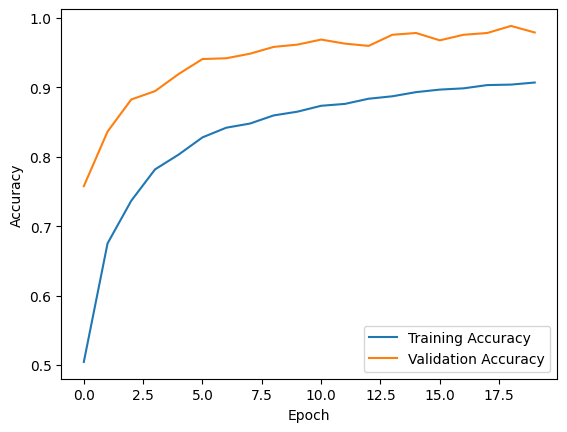

In [26]:
# Plot Training History
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9250 - loss: 0.3833
Test Accuracy: 92.47%


In [35]:
#Calculate F1-Score and AUC-ROC
from sklearn.metrics import f1_score, roc_auc_score

# Convert y_true to integer labels
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_dataset])

# Ensure y_pred_probs has shape (samples, NUM_CLASSES)
y_pred_probs = np.concatenate([model.predict(x) for x, _ in test_dataset])

# Convert probabilities to predicted classes
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate F1-Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1-Score: {f1:.2f}")

# Calculate AUC-ROC
if NUM_CLASSES == 2:
    auc_roc = roc_auc_score(y_true, y_pred_probs[:, 1])  # Use probabilities for the positive class
else:
    auc_roc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')  # Use probabilities for all classes
print(f"AUC-ROC: {auc_roc:.2f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [ ]:
# Display Example Images and Predictions
def plot_predictions(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy(), vmin=0, vmax=1)
            true_label = tf.argmax(labels[i])
            pred_label = tf.argmax(preds[i])
            plt.title(f"True: {true_label}, Pred: {pred_label}")
            plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


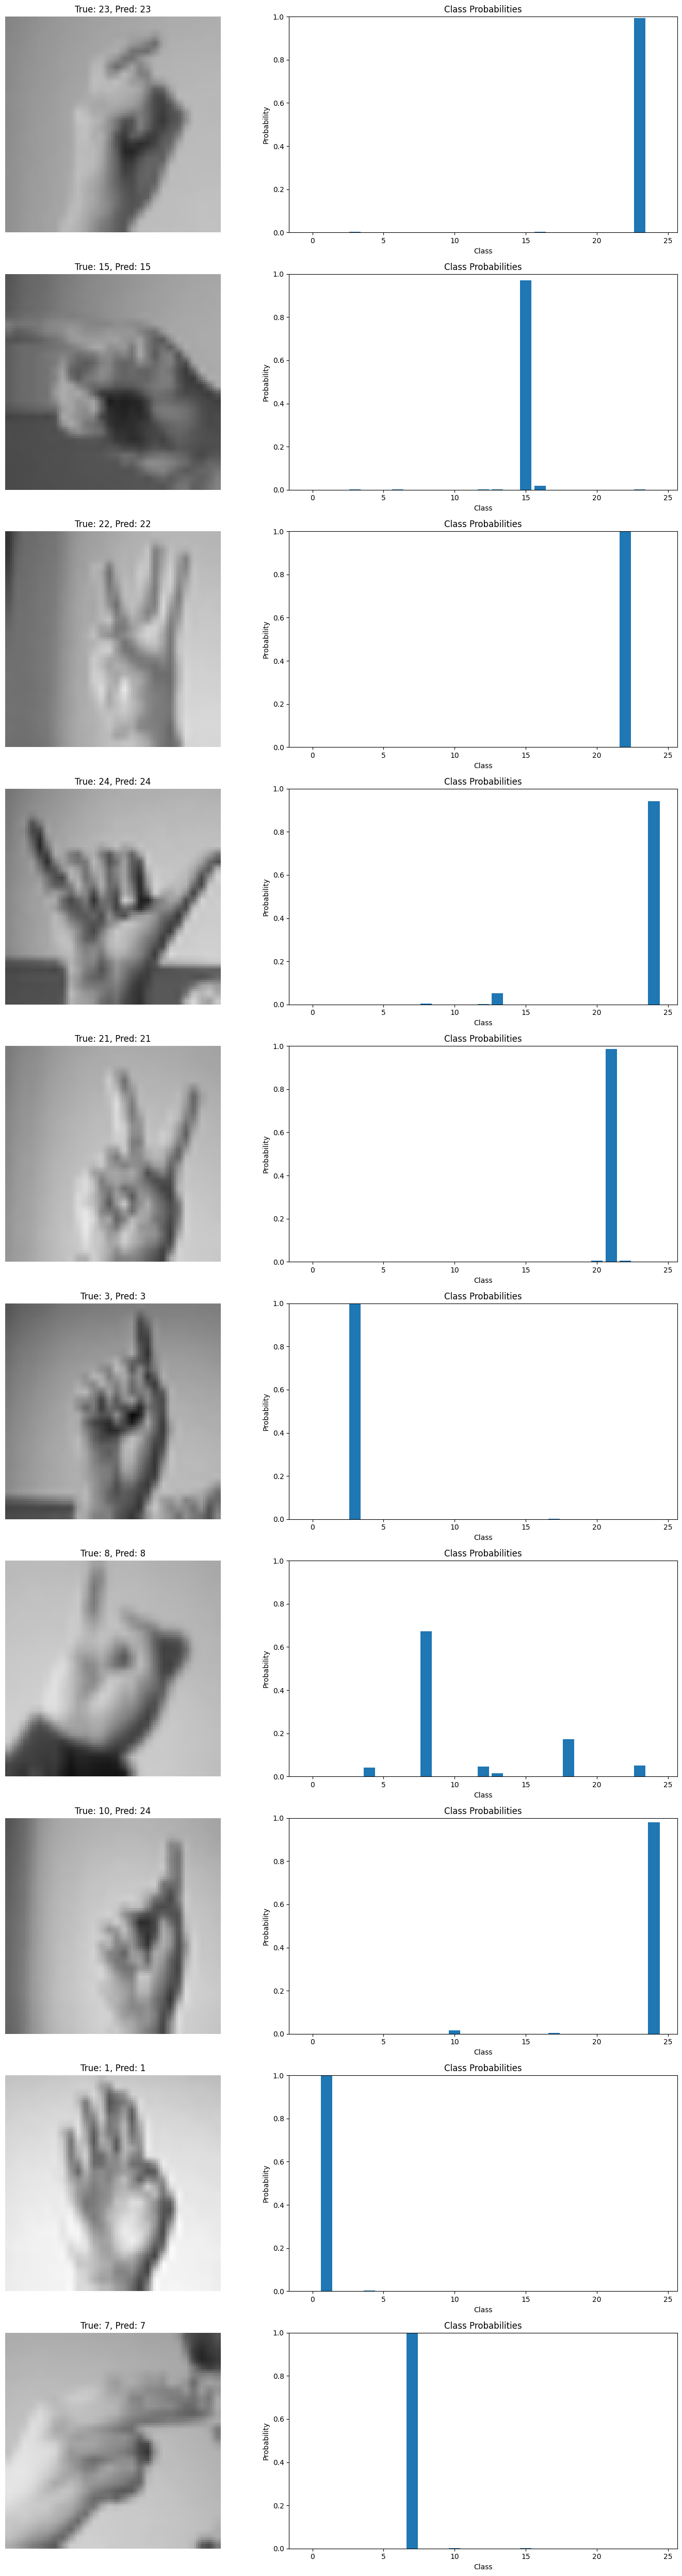

In [29]:
# Call the function to list first n examples from the test set with their predicted and actual labels
def list_first_n_examples_with_probabilities(dataset, model, n=5):
    """
    List the first n examples in the test set with their predicted and actual labels,
    and display the softmax probabilities for each output class.

    Parameters:
    - dataset: tf.data.Dataset, the test dataset to use for predictions
    - model: keras.Model, the trained model for predictions
    - n: int, number of examples to display

    Returns:
    - None
    """
    plt.figure(figsize=(15, n * 5))
    example_count = 0

     # Loop over the dataset
    for images, labels in dataset.take(1):
        # Get the model predictions
        predictions = model.predict(images)

        # Iterate over the images and labels
        for i in range(min(n, len(images))):
            true_label = tf.argmax(labels[i]).numpy()  # Actual label
            predicted_label = tf.argmax(predictions[i]).numpy()  # Predicted label
            probabilities = predictions[i]  # Softmax output - probabilities for each class

            # Plot the image
            plt.subplot(n, 2, 2 * i + 1)
            plt.imshow(images[i].numpy(), vmin=0, vmax=1)
            plt.title(f"True: {true_label}, Pred: {predicted_label}")
            plt.axis('off')

            # Plot the softmax probabilities
            plt.subplot(n, 2, 2 * i + 2)
            plt.bar(range(len(probabilities)), probabilities)
            plt.title("Class Probabilities")
            plt.xlabel("Class")
            plt.ylabel("Probability")
            plt.ylim([0, 1])

            example_count += 1
            if example_count >= n:
                break

    plt.tight_layout()
    plt.show()

list_first_n_examples_with_probabilities(test_dataset, model, n=10)